In [130]:
import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.optim import lr_scheduler

## R, 真实数据

- 这是生成真实的数据, 被用于模仿

In [156]:
def get_distribution_sampler(mu, sigma, batchSize, FeatureNum):
    """
    Generate Target Data, Gaussian
    Input
    - mu: 均值
    - sugma: 方差
    Output
    """
    return Variable(torch.Tensor(np.random.normal(mu, sigma, (batchSize, FeatureNum))))

In [157]:
data_mean = 4
data_stddev = 1.25
batch_size = 1
featureNum = 500

d_real_data = get_distribution_sampler(data_mean, data_stddev, batch_size, featureNum)

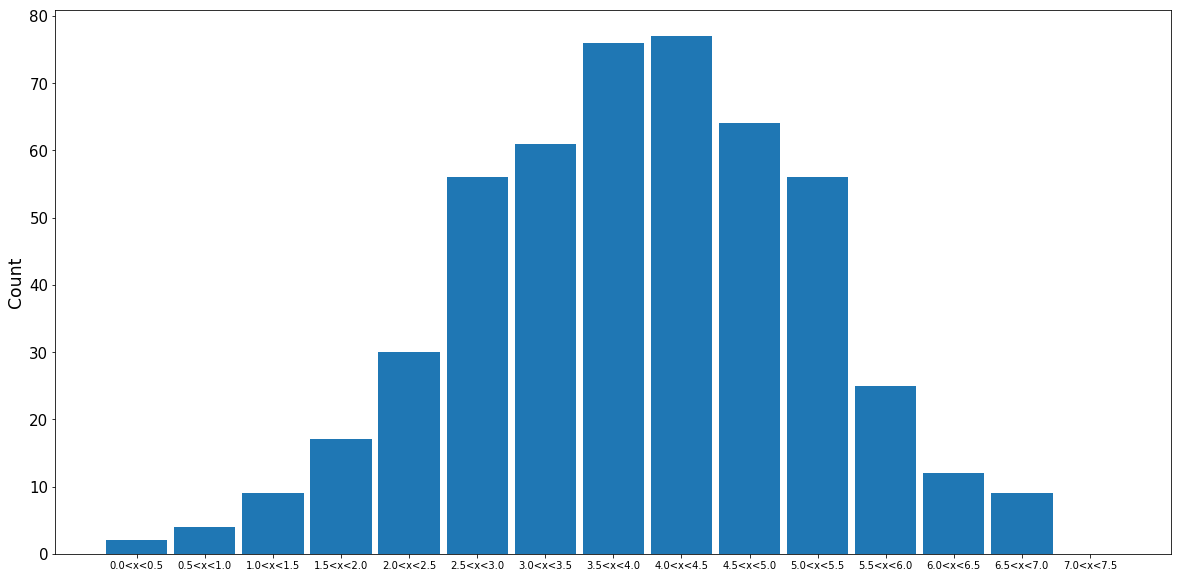

In [158]:
# ----------------------
# 计算每个范围的数据个数
# ----------------------
binRange = np.arange(0,8,0.5)
hist1,_ = np.histogram(d_real_data.numpy(), bins=binRange)

# --------
# 绘制图像
# --------
fig, ax1 = plt.subplots()
fig.set_size_inches(20, 10)
plt.set_cmap('RdBu')
x = np.arange(len(binRange)-1)
w=0.3
# 绘制多个bar在同一个图中, 这里需要控制width
plt.bar(x, hist1, width=w*3, align='center')
# 设置坐标轴的标签
ax1.yaxis.set_tick_params(labelsize=15) # 设置y轴的字体的大小
ax1.set_xticks(x) # 设置xticks出现的位置

# 创建xticks
xticksName = []
for i in range(len(binRange)-1):
    xticksName = xticksName + ['{}<x<{}'.format(str(np.round(binRange[i],1)), str(np.round(binRange[i+1],1)))]
ax1.set_xticklabels(xticksName)

# 设置坐标轴名称
ax1.set_ylabel("Count", fontsize='xx-large')
plt.show()

## I, Input Data

- 这是输出到模型中的数据

In [161]:
def get_generator_input_sampler(m, n):
    """
    Uniform-dist data into generator, _NOT_ Gaussian
    Input
    - m: 表示batchsize
    - n: 表示feature count
    Output
    - 返回的是生成数据的分布
    """
    return torch.rand(m, n)

In [173]:
g_input_size = 3
minibatch_size = 2

d_gen_input = get_generator_input_sampler(minibatch_size, g_input_size)
print(d_gen_input)

tensor([[0.0455, 0.8829, 0.0473],
        [0.3772, 0.0250, 0.0508]])


## G, generator

- generator是一个普通的前向传播网络
- generator使用的是tanh激活函数
- generator输入是均值分布(来自I的数据)
- generator的任务是模仿R中的数据, 即希望模仿正态分布的数据(generator是没有见过R的)

In [45]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, f):
        super(Generator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.f = f # 激活函数
        
    def forward(self, x):
        x = self.map1(x)
        x = self.relu(x)
        x = self.map2(x)
        x = self.relu(x)
        x = self.map3(x)
        return x

In [54]:
# 测试generator
g_input_size = 1      # Random noise dimension coming into generator, per output vector
g_hidden_size = 5     # Generator complexity
g_output_size = 1     # Size of generated output vector
generator_activation_function = torch.tanh

G = Generator(input_size=g_input_size,
              hidden_size=g_hidden_size,
              output_size=g_output_size,
              f=generator_activation_function)

G(torch.tensor([[0.5], [0.4]]))

tensor([[-0.1079],
        [-0.1068]], grad_fn=<AddmmBackward>)

## D, discriminator

- discriminator和generator一样, 也是简单的前向传播网络
- discriminator使用的是sigmoid函数
- discriminator使用R和G产生的数据
- 最后的label是0与1, 从R中的数据label是1, 从G中产生的数据label是0

In [47]:
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, f):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.f = f
    
    def forward(self, x):
        x = self.relu(self.map1(x))
        x = self.relu(self.map2(x))
        x = self.f(self.map3(x))# 最后生成的是概率
        return x

In [48]:
d_input_size = 1    # Minibatch size - cardinality of distributions
d_hidden_size = 10    # Discriminator complexity
d_output_size = 1     # Single dimension for 'real' vs. 'fake' classification
discriminator_activation_function = torch.sigmoid

D = Discriminator(input_size=d_input_size,
                  hidden_size=d_hidden_size,
                  output_size=d_output_size,
                  f=discriminator_activation_function)

D(torch.tensor([0.5]))

tensor([0.4407], grad_fn=<SigmoidBackward>)

## 辅助函数

In [220]:
def get_moments(ds):
    """
    - Return the first 4 moments of the data provided
    - 返回一个数据的四个指标, 分别是均值, 方差, 偏度, 峰读
    - 我们希望通过这四个指标, 来判断我们生成的数据是否是需要的数据
    """
    finals = []
    for d in ds:
        mean = torch.mean(d) # d的均值
        diffs = d - mean
        var = torch.mean(torch.pow(diffs, 2.0))
        std = torch.pow(var, 0.5) # d的方差
        zscores = diffs / (std+0.001) # 对原始数据 zscores = (d-mean)/std
        skews = torch.mean(torch.pow(zscores, 3.0)) # 峰度
        kurtoses = torch.mean(torch.pow(zscores, 4.0)) - 3.0  # excess kurtosis, should be 0 for Gaussian
        final = torch.cat((mean.reshape(1,), std.reshape(1,), skews.reshape(1,), kurtoses.reshape(1,)))
        # 这里返回的是高斯分布的四个特征
        finals.append(final)
    return torch.stack(finals)

In [221]:
a = get_moments(d_real_data)
a

tensor([[ 4.0332e+00,  1.2552e+00,  6.9401e-02, -6.8027e-02],
        [ 4.0931e+00,  1.3255e+00, -1.4594e-01,  3.5841e-01],
        [ 3.9680e+00,  1.2951e+00, -2.0762e-02,  1.7035e-01],
        [ 4.0107e+00,  1.2326e+00,  4.3031e-02, -1.6886e-01],
        [ 4.0904e+00,  1.2611e+00,  6.6951e-03, -1.2140e-01],
        [ 3.9738e+00,  1.2603e+00,  1.5995e-01,  2.5403e-01],
        [ 3.9556e+00,  1.2315e+00,  6.0714e-02, -1.6069e-04],
        [ 3.9410e+00,  1.3071e+00, -2.0046e-01,  3.9447e-01],
        [ 3.9433e+00,  1.2017e+00, -8.1377e-02, -1.4604e-01],
        [ 3.8634e+00,  1.2557e+00, -1.5322e-01,  2.0924e-01],
        [ 4.0587e+00,  1.2209e+00, -3.5672e-02, -1.6600e-01],
        [ 3.8929e+00,  1.2719e+00, -4.7304e-02, -1.9917e-01],
        [ 3.9527e+00,  1.2258e+00,  3.8807e-02, -4.9039e-02],
        [ 4.0590e+00,  1.2330e+00, -5.2259e-03, -2.3496e-01],
        [ 4.0531e+00,  1.2911e+00, -5.7904e-02, -1.5150e-01],
        [ 4.0074e+00,  1.2593e+00,  1.4615e-01, -2.4936e-01],
        

## Training

- 首先训练D, 我们使用real data vs. fake data, with accurate labels
- 接着我们训练G来使得其生成的数据无法被D正确分辨(这时候fix住D的参数, 使得G产生数据, 使得D预测的label是1)
- 接着重复上面的两个操作

In [232]:
d_input_size = 4
d_hidden_size = 10
d_output_size = 1
discriminator_activation_function = torch.sigmoid

g_input_size = 50
g_output_size = 200
g_output_size = 500
generator_activation_function = torch.tanh

featureNum = g_output_size # 一组样本有500个服从正太分布的数据
minibatch_size = 10 # batch_size的大小

num_epochs = 2001
d_steps = 20 # discriminator的训练轮数
g_steps = 20 # generator的训练轮数

# ----------
# 初始化网络
# ----------
D = Discriminator(input_size=d_input_size,
                  hidden_size=d_hidden_size,
                  output_size=d_output_size,
                  f=discriminator_activation_function)


G = Generator(input_size=g_input_size,
              hidden_size=g_hidden_size,
              output_size=g_output_size,
              f=generator_activation_function)

# ----------------------
# 初始化优化器和损失函数
# ----------------------
d_learning_rate = 0.0001
g_learning_rate = 0.0001


criterion = nn.BCELoss()  # Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss
d_optimizer = optim.Adam(D.parameters(), lr=d_learning_rate)
g_optimizer = optim.Adam(G.parameters(), lr=g_learning_rate)

d_exp_lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(d_optimizer, T_max = d_steps*5, eta_min=0.00001)
g_exp_lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(g_optimizer, T_max = g_steps*5, eta_min=0.00001)


G_mean = [] # 生成器生成的数据的均值
G_std = [] # 生成器生成的数据的方差
    
for epoch in range(num_epochs):
    # -------------------
    # Train the Detective
    # -------------------
    for d_index in range(d_steps):
        # Train D on real+fake
        d_exp_lr_scheduler.step()
        D.zero_grad()
        
        # Train D on real, 这里的label是1
        d_real_data = get_distribution_sampler(data_mean, data_stddev, minibatch_size, featureNum) # 真实的样本
        d_real_decision = D(get_moments(d_real_data)) # 求出数据的四个重要特征
        d_real_error = criterion(d_real_decision, Variable(torch.ones([minibatch_size, 1]))) # 计算error
        d_real_error.backward() # 进行反向传播
        
        # Train D on fake, 这里的label是0
        d_gen_input = get_generator_input_sampler(minibatch_size, g_input_size)
        d_fake_data = G(d_gen_input)
        d_fake_decision = D(get_moments(d_fake_data))
        d_fake_error = criterion(d_fake_decision, Variable(torch.zeros([minibatch_size, 1])))
        d_fake_error.backward()
        
        # Optimizer
        d_optimizer.step()
        
    # -------------------
    # Train the Generator
    # -------------------
    for g_index in range(g_steps):
        # Train G on D's response(使得G生成的x让D判断为1)
        g_exp_lr_scheduler.step()
        G.zero_grad()
        
        gen_input = get_generator_input_sampler(minibatch_size, g_input_size)
        g_fake_data = G(gen_input) # 使得generator生成样本
        dg_fake_decision = D(get_moments(g_fake_data)) # D来做的判断
        g_error = criterion(dg_fake_decision, Variable(torch.ones([minibatch_size, 1])))
        
        G_mean.append(g_fake_data.mean().item())
        G_std.append(g_fake_data.std().item())
        
        g_error.backward()
        g_optimizer.step()
    
    if epoch%10==0:
        print("Epoch: {}, G data's Mean: {}, G data's Std: {}".format(epoch, G_mean[-1], G_std[-1]))
        print("Epoch: {}, Real data's Mean: {}, Real data's Std: {}".format(epoch, d_real_data.mean().item(), d_real_data.std().item()))
        print('-'*10)

Epoch: 0, G data's Mean: 0.01499362476170063, G data's Std: 0.2619698643684387
Epoch: 0, Real data's Mean: 3.987595319747925, Real data's Std: 1.2557897567749023
----------
Epoch: 10, G data's Mean: 0.02581474371254444, G data's Std: 0.302983820438385
Epoch: 10, Real data's Mean: 3.9957711696624756, Real data's Std: 1.2412000894546509
----------
Epoch: 20, G data's Mean: 0.03552306443452835, G data's Std: 0.3466247320175171
Epoch: 20, Real data's Mean: 3.9958057403564453, Real data's Std: 1.2097889184951782
----------
Epoch: 30, G data's Mean: 0.040229432284832, G data's Std: 0.3643871247768402
Epoch: 30, Real data's Mean: 3.9752023220062256, Real data's Std: 1.260635495185852
----------
Epoch: 40, G data's Mean: 0.03708142787218094, G data's Std: 0.3910966217517853
Epoch: 40, Real data's Mean: 4.000041961669922, Real data's Std: 1.2542555332183838
----------
Epoch: 50, G data's Mean: 0.0215773768723011, G data's Std: 0.40092799067497253
Epoch: 50, Real data's Mean: 3.9829065799713135,

Epoch: 470, G data's Mean: 3.498357057571411, G data's Std: 1.186673641204834
Epoch: 470, Real data's Mean: 3.9739747047424316, Real data's Std: 1.239910364151001
----------
Epoch: 480, G data's Mean: 3.668012857437134, G data's Std: 1.5508793592453003
Epoch: 480, Real data's Mean: 4.005486488342285, Real data's Std: 1.248317003250122
----------
Epoch: 490, G data's Mean: 3.7579331398010254, G data's Std: 1.6896635293960571
Epoch: 490, Real data's Mean: 4.027507305145264, Real data's Std: 1.2493422031402588
----------
Epoch: 500, G data's Mean: 4.1743950843811035, G data's Std: 1.806605339050293
Epoch: 500, Real data's Mean: 4.052405834197998, Real data's Std: 1.2414629459381104
----------
Epoch: 510, G data's Mean: 4.131259441375732, G data's Std: 1.642133355140686
Epoch: 510, Real data's Mean: 4.021630764007568, Real data's Std: 1.2668845653533936
----------
Epoch: 520, G data's Mean: 4.555051326751709, G data's Std: 1.4858685731887817
Epoch: 520, Real data's Mean: 3.965212106704712,

Epoch: 940, G data's Mean: 4.0865325927734375, G data's Std: 1.4349788427352905
Epoch: 940, Real data's Mean: 3.9972527027130127, Real data's Std: 1.2473061084747314
----------
Epoch: 950, G data's Mean: 4.413910865783691, G data's Std: 1.2394688129425049
Epoch: 950, Real data's Mean: 3.978560209274292, Real data's Std: 1.2440435886383057
----------
Epoch: 960, G data's Mean: 3.976346492767334, G data's Std: 1.1854161024093628
Epoch: 960, Real data's Mean: 3.956742525100708, Real data's Std: 1.239466905593872
----------
Epoch: 970, G data's Mean: 3.6465554237365723, G data's Std: 1.343820571899414
Epoch: 970, Real data's Mean: 4.022999286651611, Real data's Std: 1.256170392036438
----------
Epoch: 980, G data's Mean: 4.249229907989502, G data's Std: 1.3849353790283203
Epoch: 980, Real data's Mean: 3.9920811653137207, Real data's Std: 1.2393858432769775
----------
Epoch: 990, G data's Mean: 4.086109638214111, G data's Std: 1.1342217922210693
Epoch: 990, Real data's Mean: 4.0069341659545

Epoch: 1410, G data's Mean: 4.334843158721924, G data's Std: 1.4242401123046875
Epoch: 1410, Real data's Mean: 4.009180545806885, Real data's Std: 1.2449122667312622
----------
Epoch: 1420, G data's Mean: 3.7282838821411133, G data's Std: 1.1516683101654053
Epoch: 1420, Real data's Mean: 3.9732401371002197, Real data's Std: 1.23626708984375
----------
Epoch: 1430, G data's Mean: 3.7964110374450684, G data's Std: 1.2536402940750122
Epoch: 1430, Real data's Mean: 4.015299320220947, Real data's Std: 1.2498705387115479
----------
Epoch: 1440, G data's Mean: 4.101872444152832, G data's Std: 1.2663002014160156
Epoch: 1440, Real data's Mean: 3.9859414100646973, Real data's Std: 1.2723385095596313
----------
Epoch: 1450, G data's Mean: 4.227709770202637, G data's Std: 1.3715945482254028
Epoch: 1450, Real data's Mean: 3.979530096054077, Real data's Std: 1.227043867111206
----------
Epoch: 1460, G data's Mean: 3.7285995483398438, G data's Std: 1.2340092658996582
Epoch: 1460, Real data's Mean: 3.

Epoch: 1880, G data's Mean: 3.97902774810791, G data's Std: 1.1893728971481323
Epoch: 1880, Real data's Mean: 4.001302719116211, Real data's Std: 1.2378510236740112
----------
Epoch: 1890, G data's Mean: 3.8588573932647705, G data's Std: 1.3453506231307983
Epoch: 1890, Real data's Mean: 4.014003753662109, Real data's Std: 1.2569358348846436
----------
Epoch: 1900, G data's Mean: 3.973820209503174, G data's Std: 1.3919610977172852
Epoch: 1900, Real data's Mean: 3.988581657409668, Real data's Std: 1.2557896375656128
----------
Epoch: 1910, G data's Mean: 4.3068437576293945, G data's Std: 1.2393555641174316
Epoch: 1910, Real data's Mean: 3.9958672523498535, Real data's Std: 1.252171516418457
----------
Epoch: 1920, G data's Mean: 3.8014585971832275, G data's Std: 1.20863938331604
Epoch: 1920, Real data's Mean: 4.002895832061768, Real data's Std: 1.2515466213226318
----------
Epoch: 1930, G data's Mean: 3.8651702404022217, G data's Std: 1.468323826789856
Epoch: 1930, Real data's Mean: 3.97

## 最终的结果分析

- 绘制出G产生数据的分布
- 绘制出mean的变化曲线
- 绘制出std的变化曲线

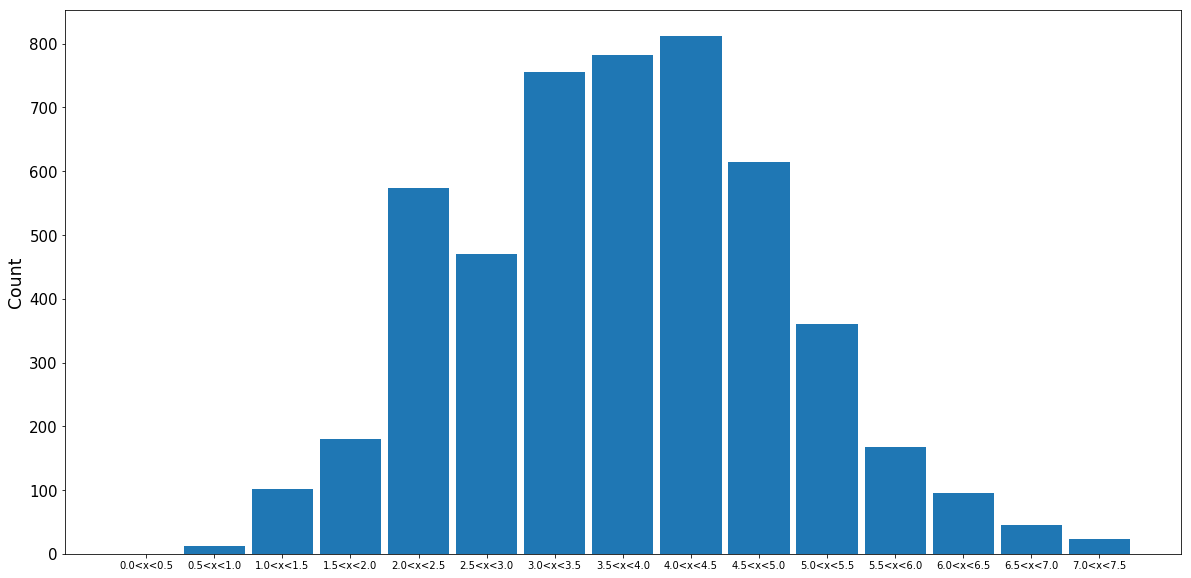

In [233]:
# ----------------------
# 计算每个范围的数据个数
# ----------------------
binRange = np.arange(0,8,0.5)
hist1,_ = np.histogram(g_fake_data.squeeze().detach().numpy(), bins=binRange)

# --------
# 绘制图像
# --------
fig, ax1 = plt.subplots()
fig.set_size_inches(20, 10)
plt.set_cmap('RdBu')
x = np.arange(len(binRange)-1)
w=0.3
# 绘制多个bar在同一个图中, 这里需要控制width
plt.bar(x, hist1, width=w*3, align='center')
# 设置坐标轴的标签
ax1.yaxis.set_tick_params(labelsize=15) # 设置y轴的字体的大小
ax1.set_xticks(x) # 设置xticks出现的位置

# 创建xticks
xticksName = []
for i in range(len(binRange)-1):
    xticksName = xticksName + ['{}<x<{}'.format(str(np.round(binRange[i],1)), str(np.round(binRange[i+1],1)))]
ax1.set_xticklabels(xticksName)

# 设置坐标轴名称
ax1.set_ylabel("Count", fontsize='xx-large')
plt.show()

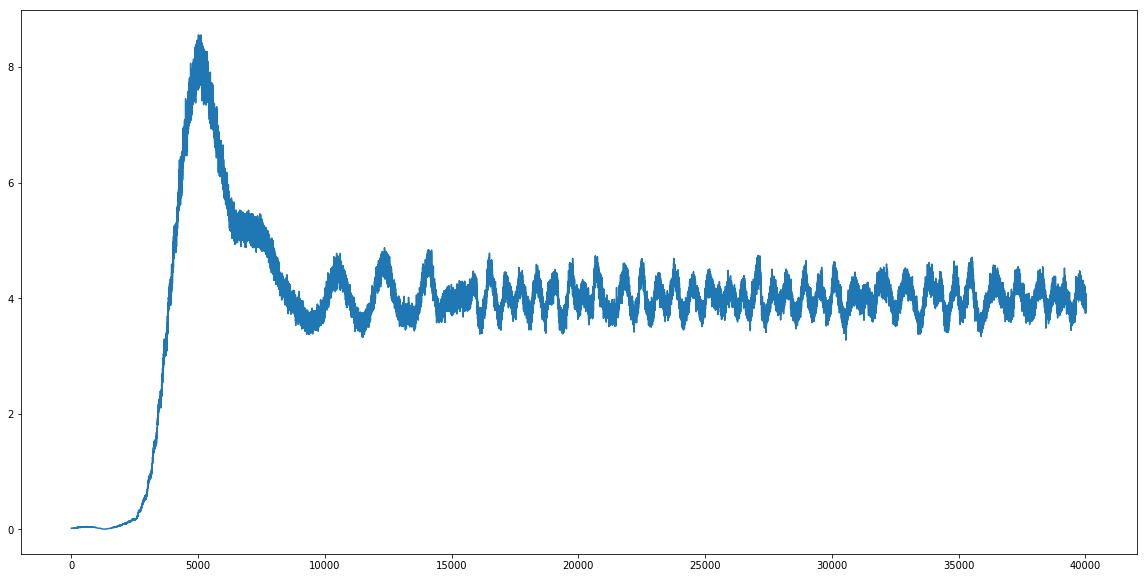

In [234]:
fig, ax1 = plt.subplots()
fig.set_size_inches(20, 10)

ax1.plot(G_mean)

plt.show()

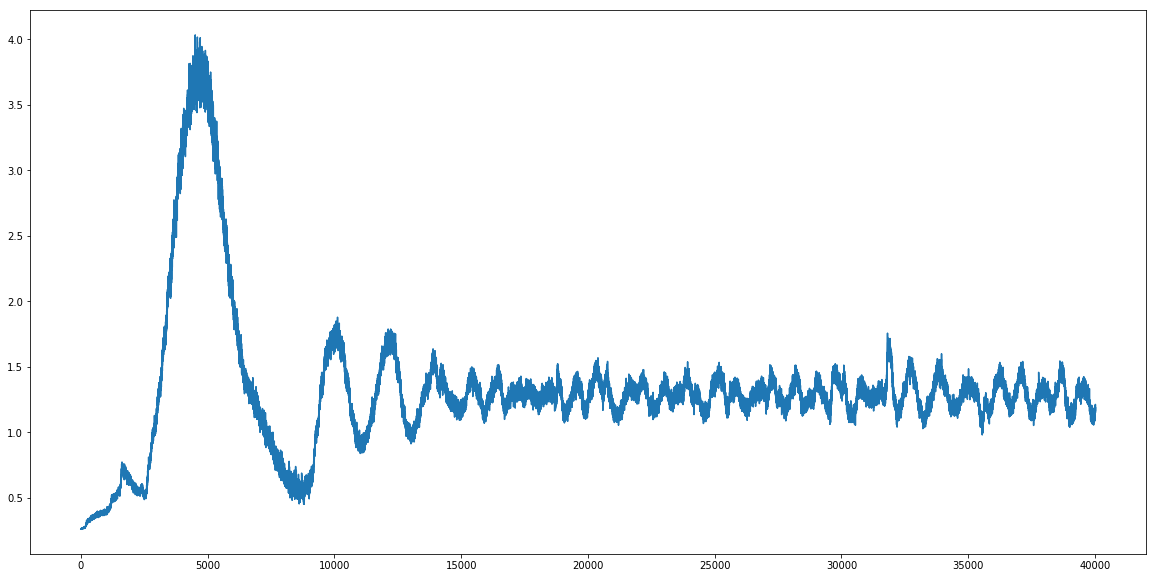

In [235]:
fig, ax1 = plt.subplots()
fig.set_size_inches(20, 10)

ax1.plot(G_std)

plt.show()